In [1]:
## 
# alogirhtm breakdown basic
# chunking in windows to produce loading intensity

# imports
import os
import matplotlib.pyplot as plt
import helpers as h # contains the computations
import numpy as np
import pandas as pd
import json

# read in the files from data directory

left_file_path = "data/test_sr7_Left_Ankle_60.csv"
right_file_path = "data/test_sr7_Right_Ankle_60.csv"

# reads the csv into a pandas data frame
left_data = pd.read_csv(left_file_path)
right_data = pd.read_csv(right_file_path)

# view the data frame 
left_data.head(5)

,PacketCounter,SampleTimeFine,Quat_W,Quat_X,Quat_Y,Quat_Z,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z
0,1,1379299623,0.457674,0.523392,-0.248966,0.674248,0.203349,-0.050982,-0.063441,0.003965,0.720417,-0.044824
1,2,1379316290,0.457346,0.524902,-0.247761,0.673741,15.539992,2.535506,5.602706,0.071517,3.333358,-0.522883
2,3,1379332957,0.458771,0.524106,-0.246372,0.673902,15.549551,2.595746,5.410692,0.811583,2.984949,0.174903
3,4,1379349624,0.459835,0.524170,-0.245480,0.673451,15.588773,2.589858,5.529365,0.280120,2.906741,0.435512
4,5,1379366291,0.460142,0.524217,-0.244501,0.673562,15.749998,2.381147,5.453948,0.315119,2.863813,0.447844


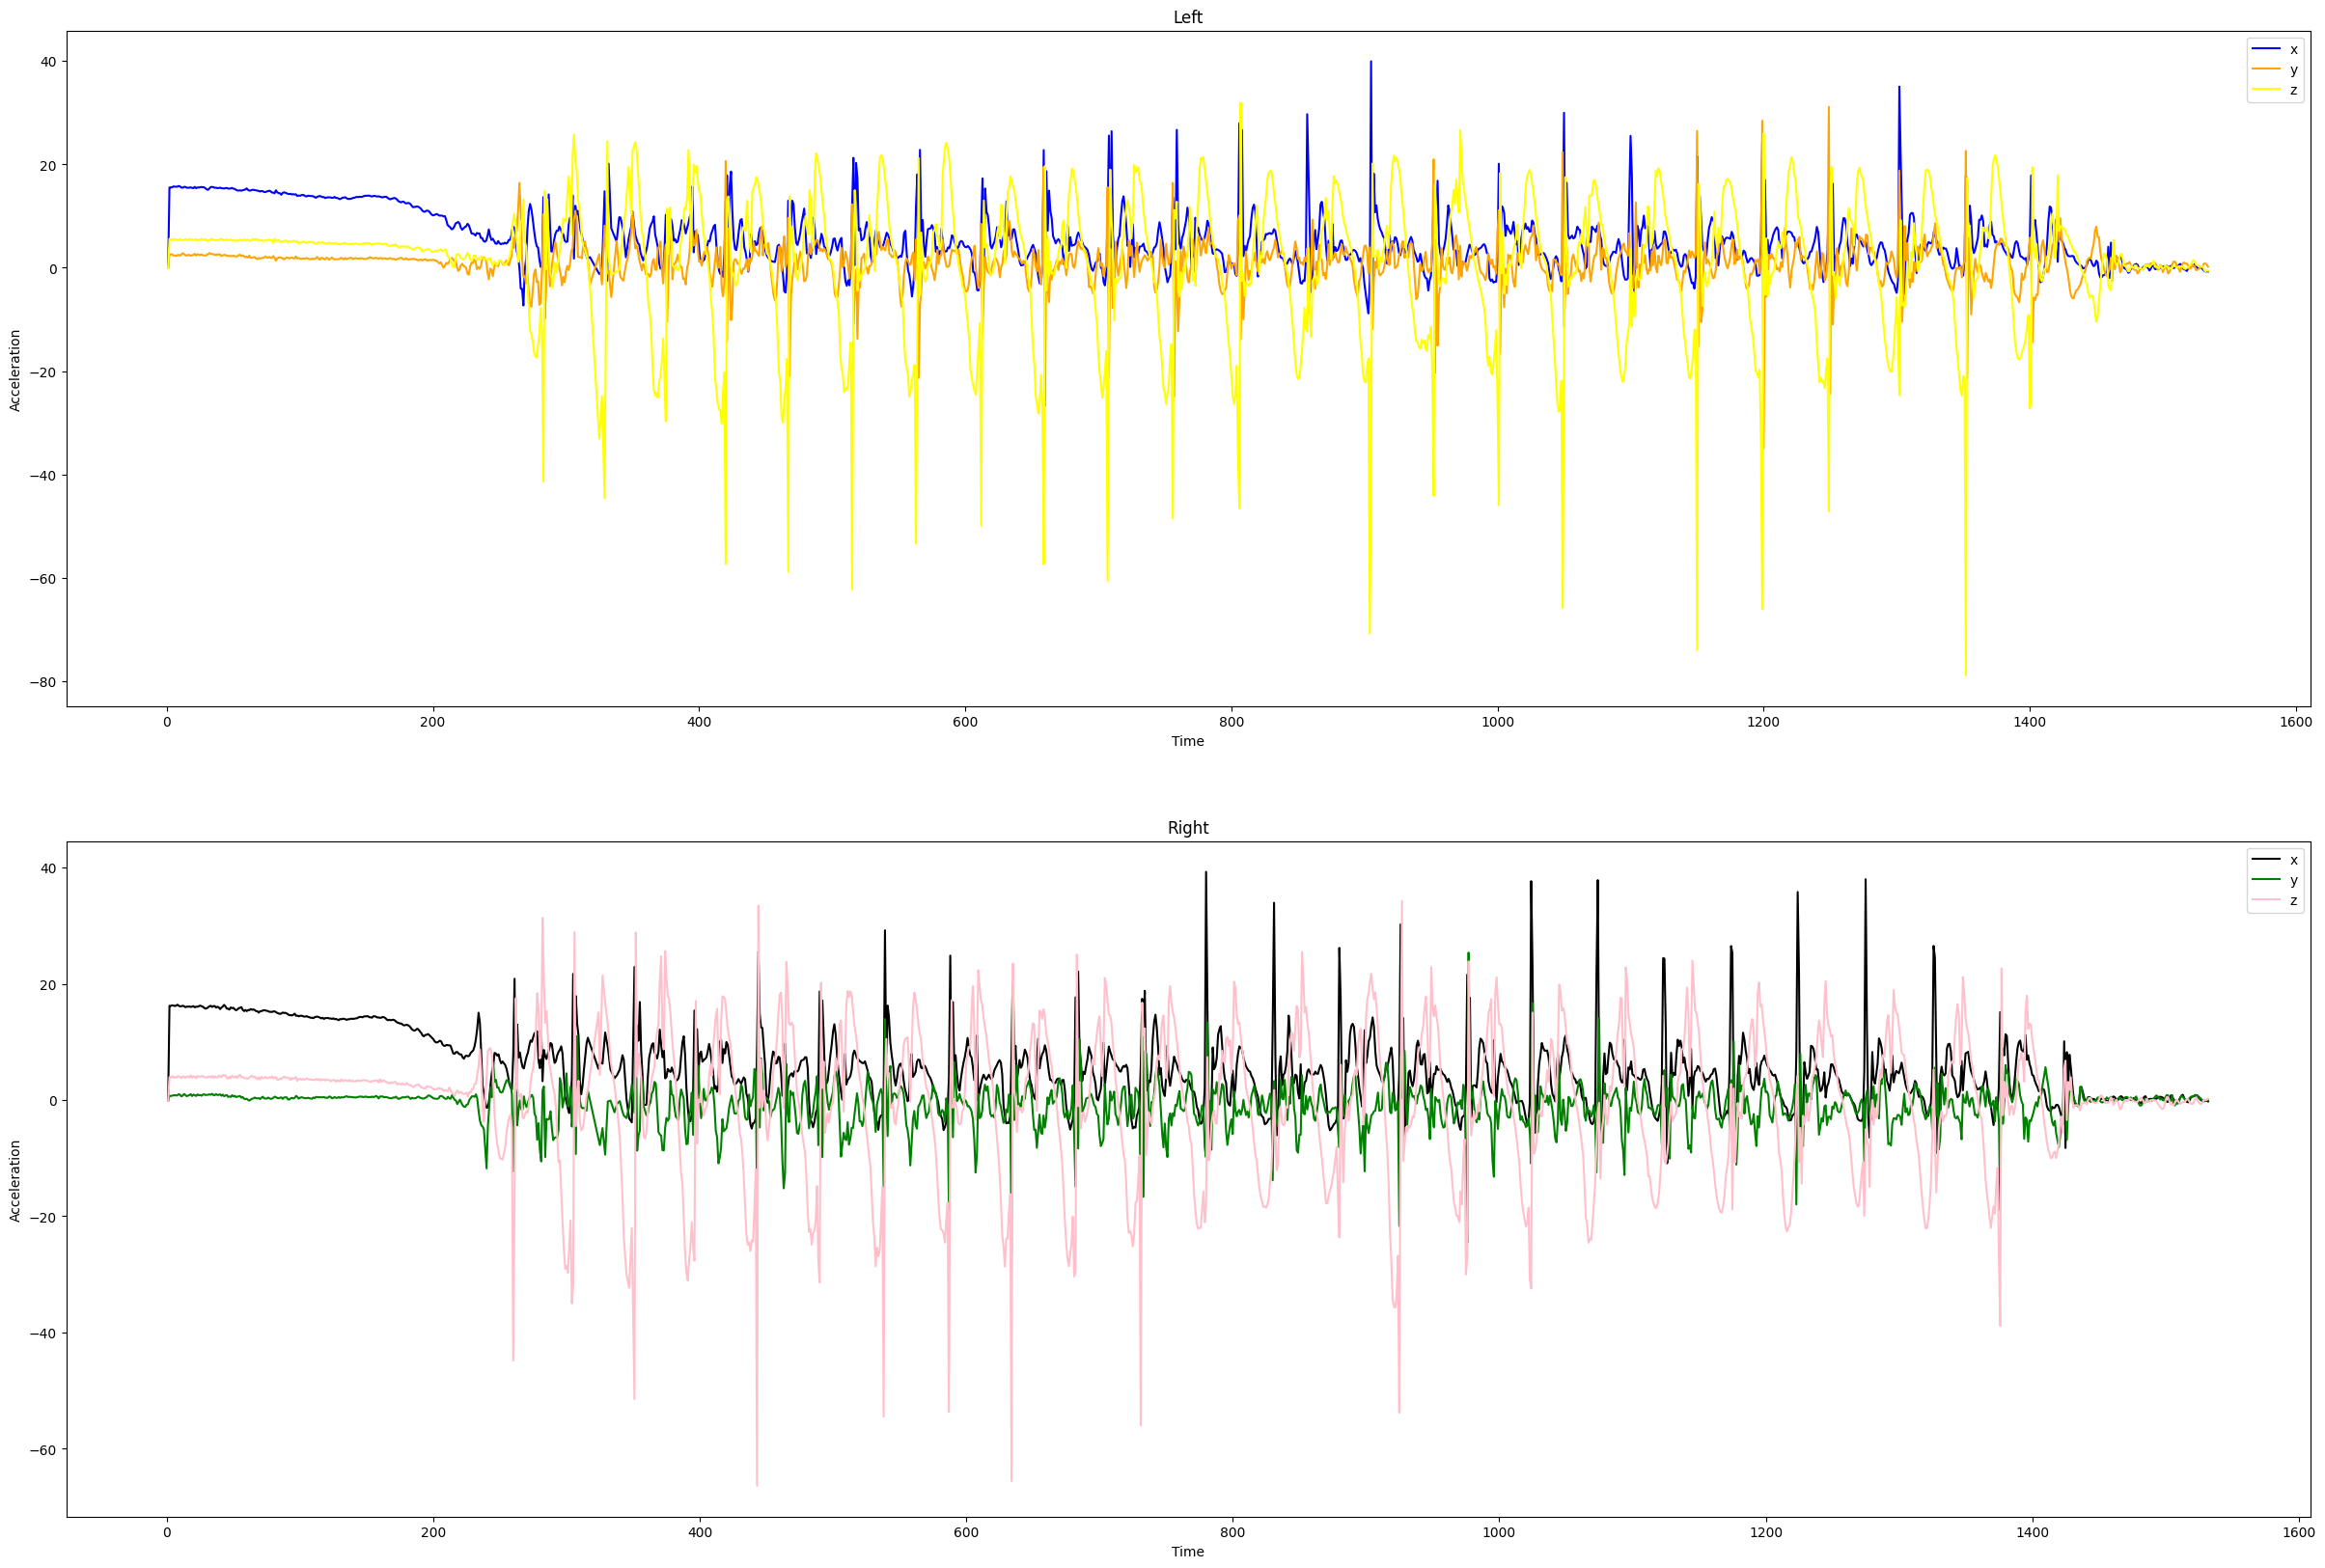

In [2]:
# explore the raw data

# extract the columns from the data frame

# left
l_pc =  left_data["PacketCounter"]
l_a_x = left_data["Acc_X"]
l_a_y = left_data["Acc_Y"]
l_a_z = left_data["Acc_Z"]

# right
r_pc =  right_data["PacketCounter"]
r_a_x = right_data["Acc_X"]
r_a_y = right_data["Acc_Y"]
r_a_z = right_data["Acc_Z"]

# plotting example
fig, ax = plt.subplots(2,1, figsize=(30, 20))

# Add labels, title, and legend
ax[0].plot(l_pc, l_a_x, color="blue", label="x")
ax[0].plot(l_pc, l_a_y, color="orange", label="y")
ax[0].plot(l_pc, l_a_z, color="yellow", label="z")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Acceleration')
ax[0].set_title('Left')
ax[0].legend()

ax[1].plot(r_pc, r_a_x, color="black", label="x")
ax[1].plot(r_pc, r_a_y, color="green", label="y")
ax[1].plot(r_pc, r_a_z, color="pink", label="z")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Acceleration')
ax[1].set_title('Right')
ax[1].legend()


In [3]:
# normalise to BW by dividing by g
g = 9.80665
l_a_x_norm = l_a_x.to_numpy()  / g
l_a_y_norm = l_a_y.to_numpy()  / g
l_a_z_norm = l_a_z.to_numpy()  / g

r_a_x_norm = r_a_x.to_numpy()  / g
r_a_y_norm = r_a_y.to_numpy()  / g
r_a_z_norm = r_a_z.to_numpy()  / g

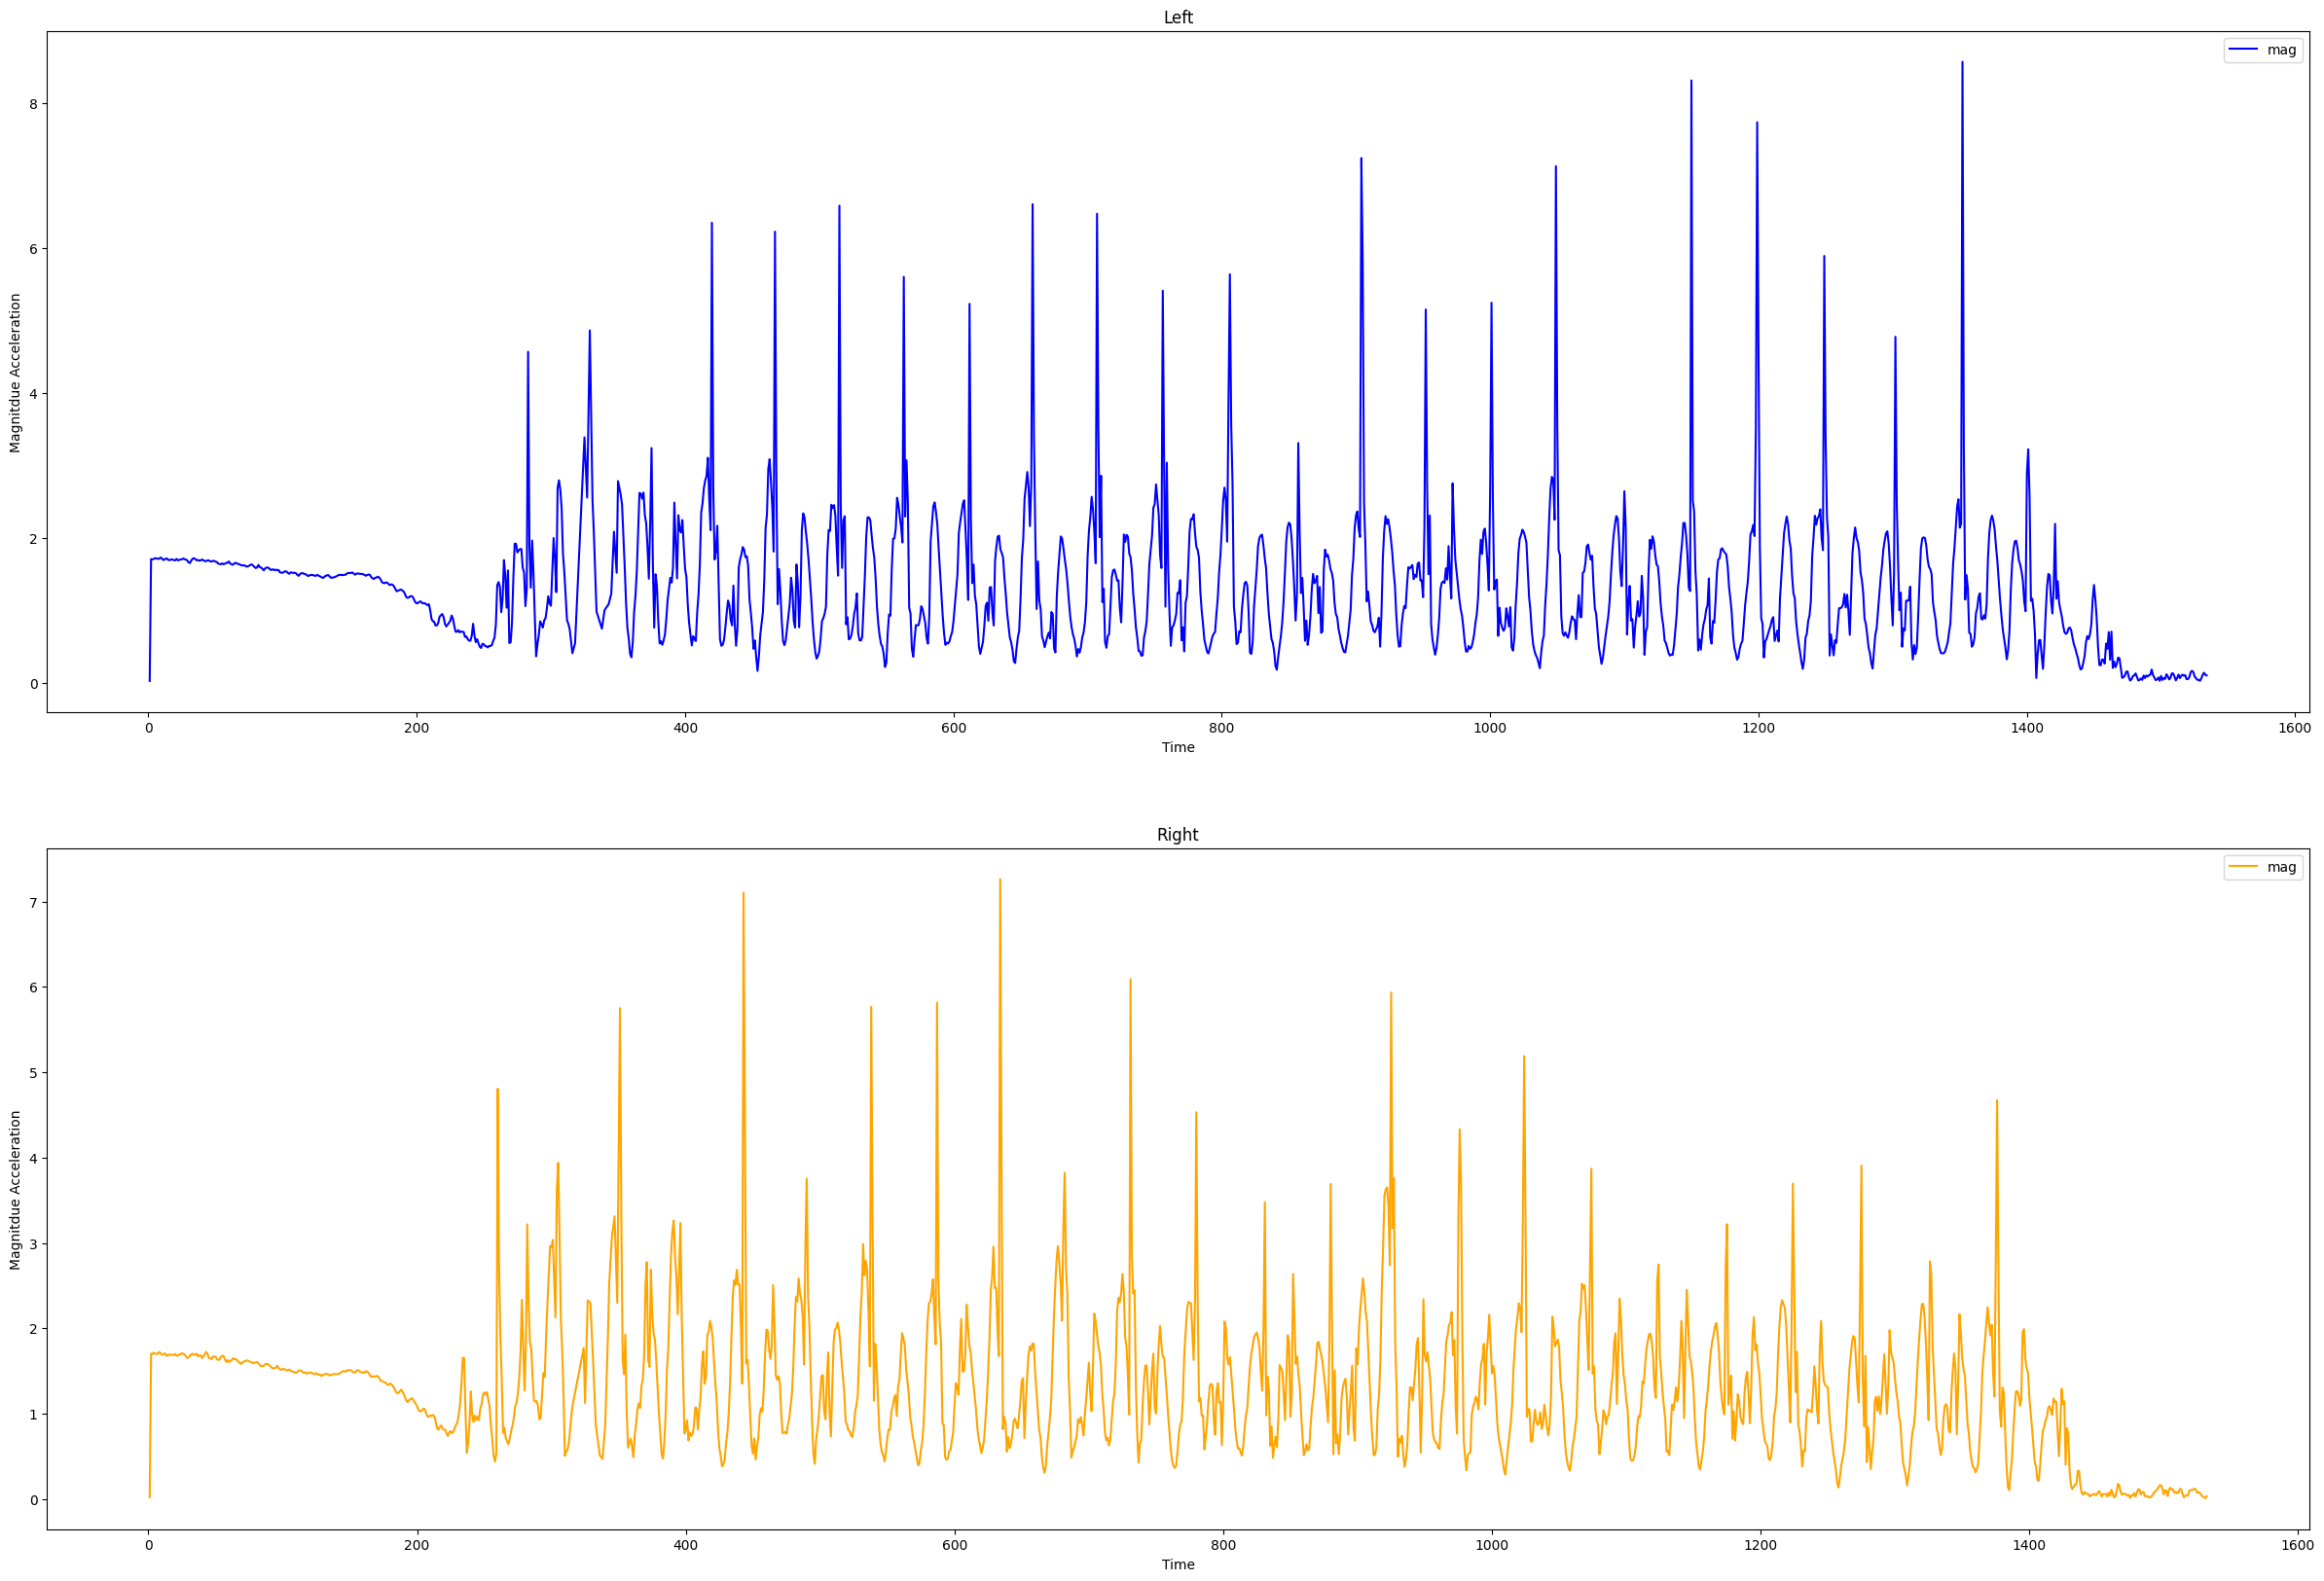

In [5]:
#  compute the magnitdue vector

# function to compute (also in helpers)
def vector_magnitude(vectors):
    n = len(vectors[0])
    assert all(len(v) == n for v in vectors), "Vectors have different lengths"
    vm = np.sqrt(sum(v ** 2 for v in vectors))
    return vm
    
l_mag = vector_magnitude([l_a_x_norm, l_a_y_norm, l_a_z_norm])
r_mag = vector_magnitude([r_a_x_norm, r_a_y_norm, r_a_z_norm])

fig, ax = plt.subplots(2,1, figsize=(30, 20))

# Add labels, title, and legend
ax[0].plot(l_pc, l_mag, color="blue", label="mag")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Magnitdue Acceleration')
ax[0].set_title('Left')
ax[0].legend()

ax[1].plot(r_pc, r_mag, color="orange", label="mag")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Magnitdue Acceleration')
ax[1].set_title('Right')
ax[1].legend()


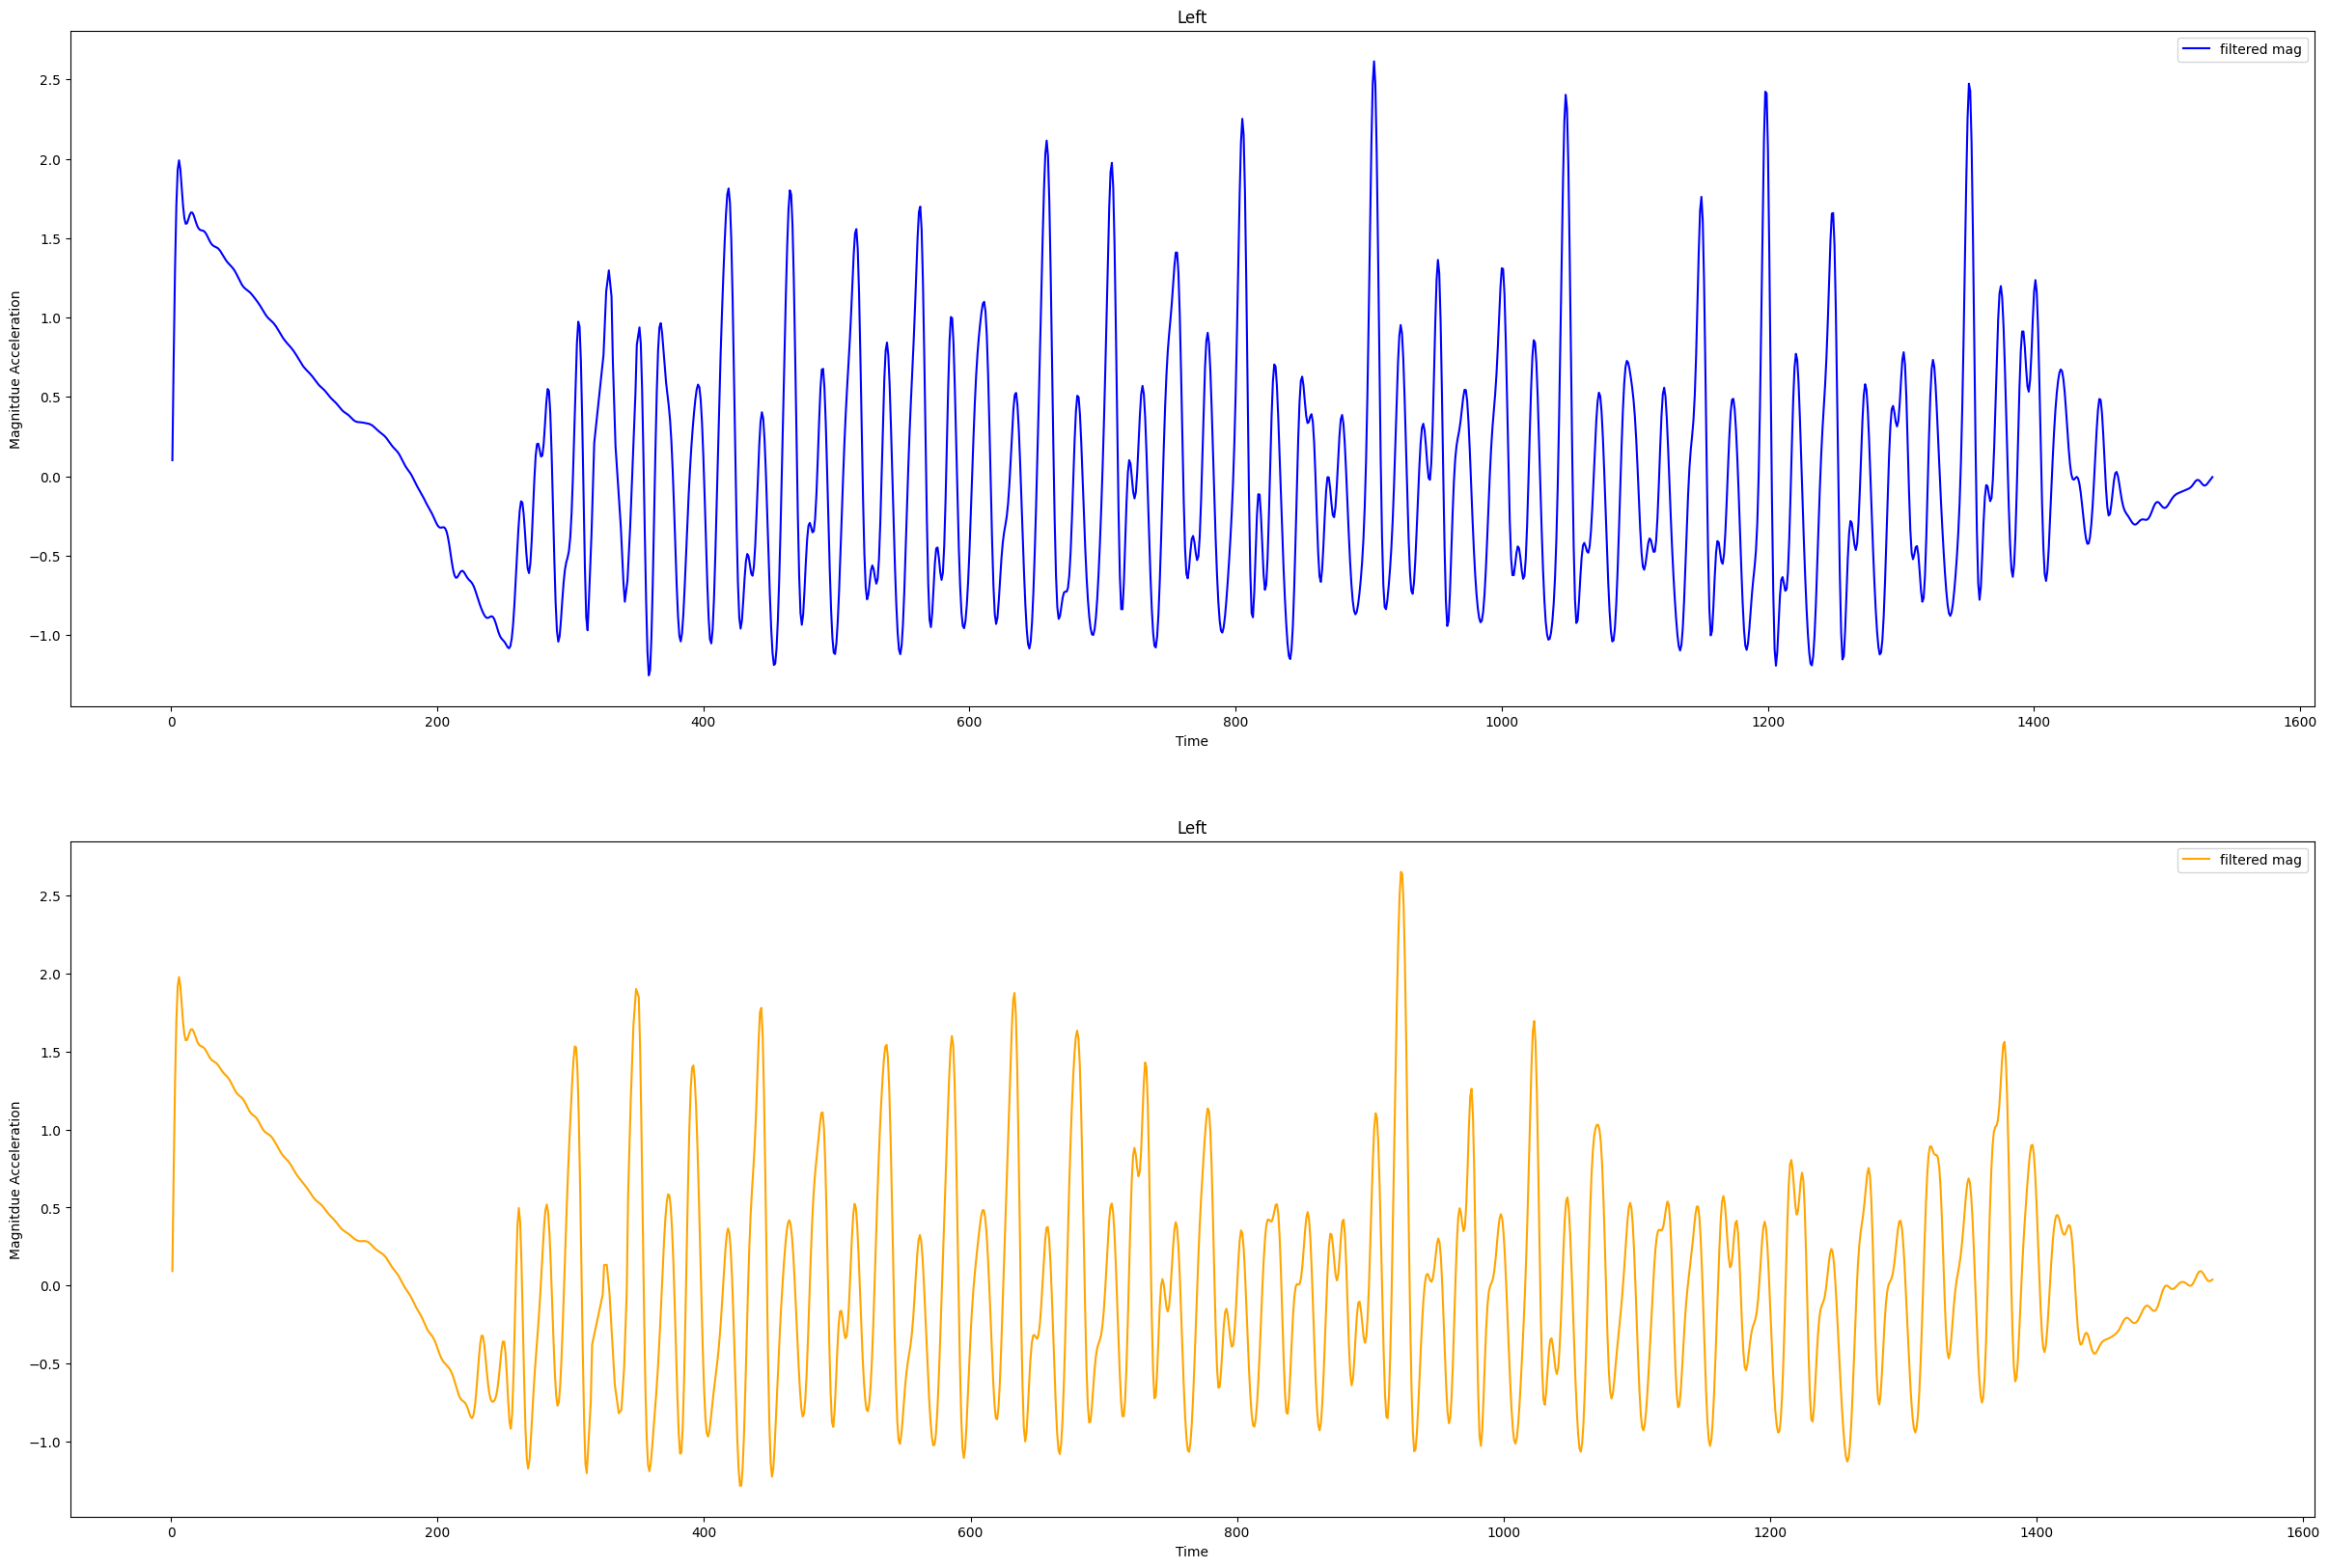

In [6]:
# filtering

# data is typically bandpass filtered between 0.1Hz and 6Hz
# these can be varied to see the effects

# build a filter (compute the coefficients)
lc_off = 0.1
hc_off = 6
sampling_rate = 60
filter_type = "bandpass" 
filter_order = 5

b,a = h.build_filter((lc_off, hc_off), sampling_rate, filter_type, filter_order)

# filtfilt filters twice, lfilter in one direction
l_filtered_mag = h.filter_signal(b,a, l_mag, "filtfilt")
r_filtered_mag = h.filter_signal(b,a, r_mag, "filtfilt")


# should really move this to a helper function
fig, ax = plt.subplots(2,1, figsize=(30, 20))

# Add labels, title, and legend
ax[0].plot(l_pc, l_filtered_mag, color="blue", label="filtered mag")
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Magnitdue Acceleration')
ax[0].set_title('Left')
ax[0].legend()

ax[1].plot(r_pc, r_filtered_mag, color="orange", label="filtered mag")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Magnitdue Acceleration')
ax[1].set_title('Left')
ax[1].legend()

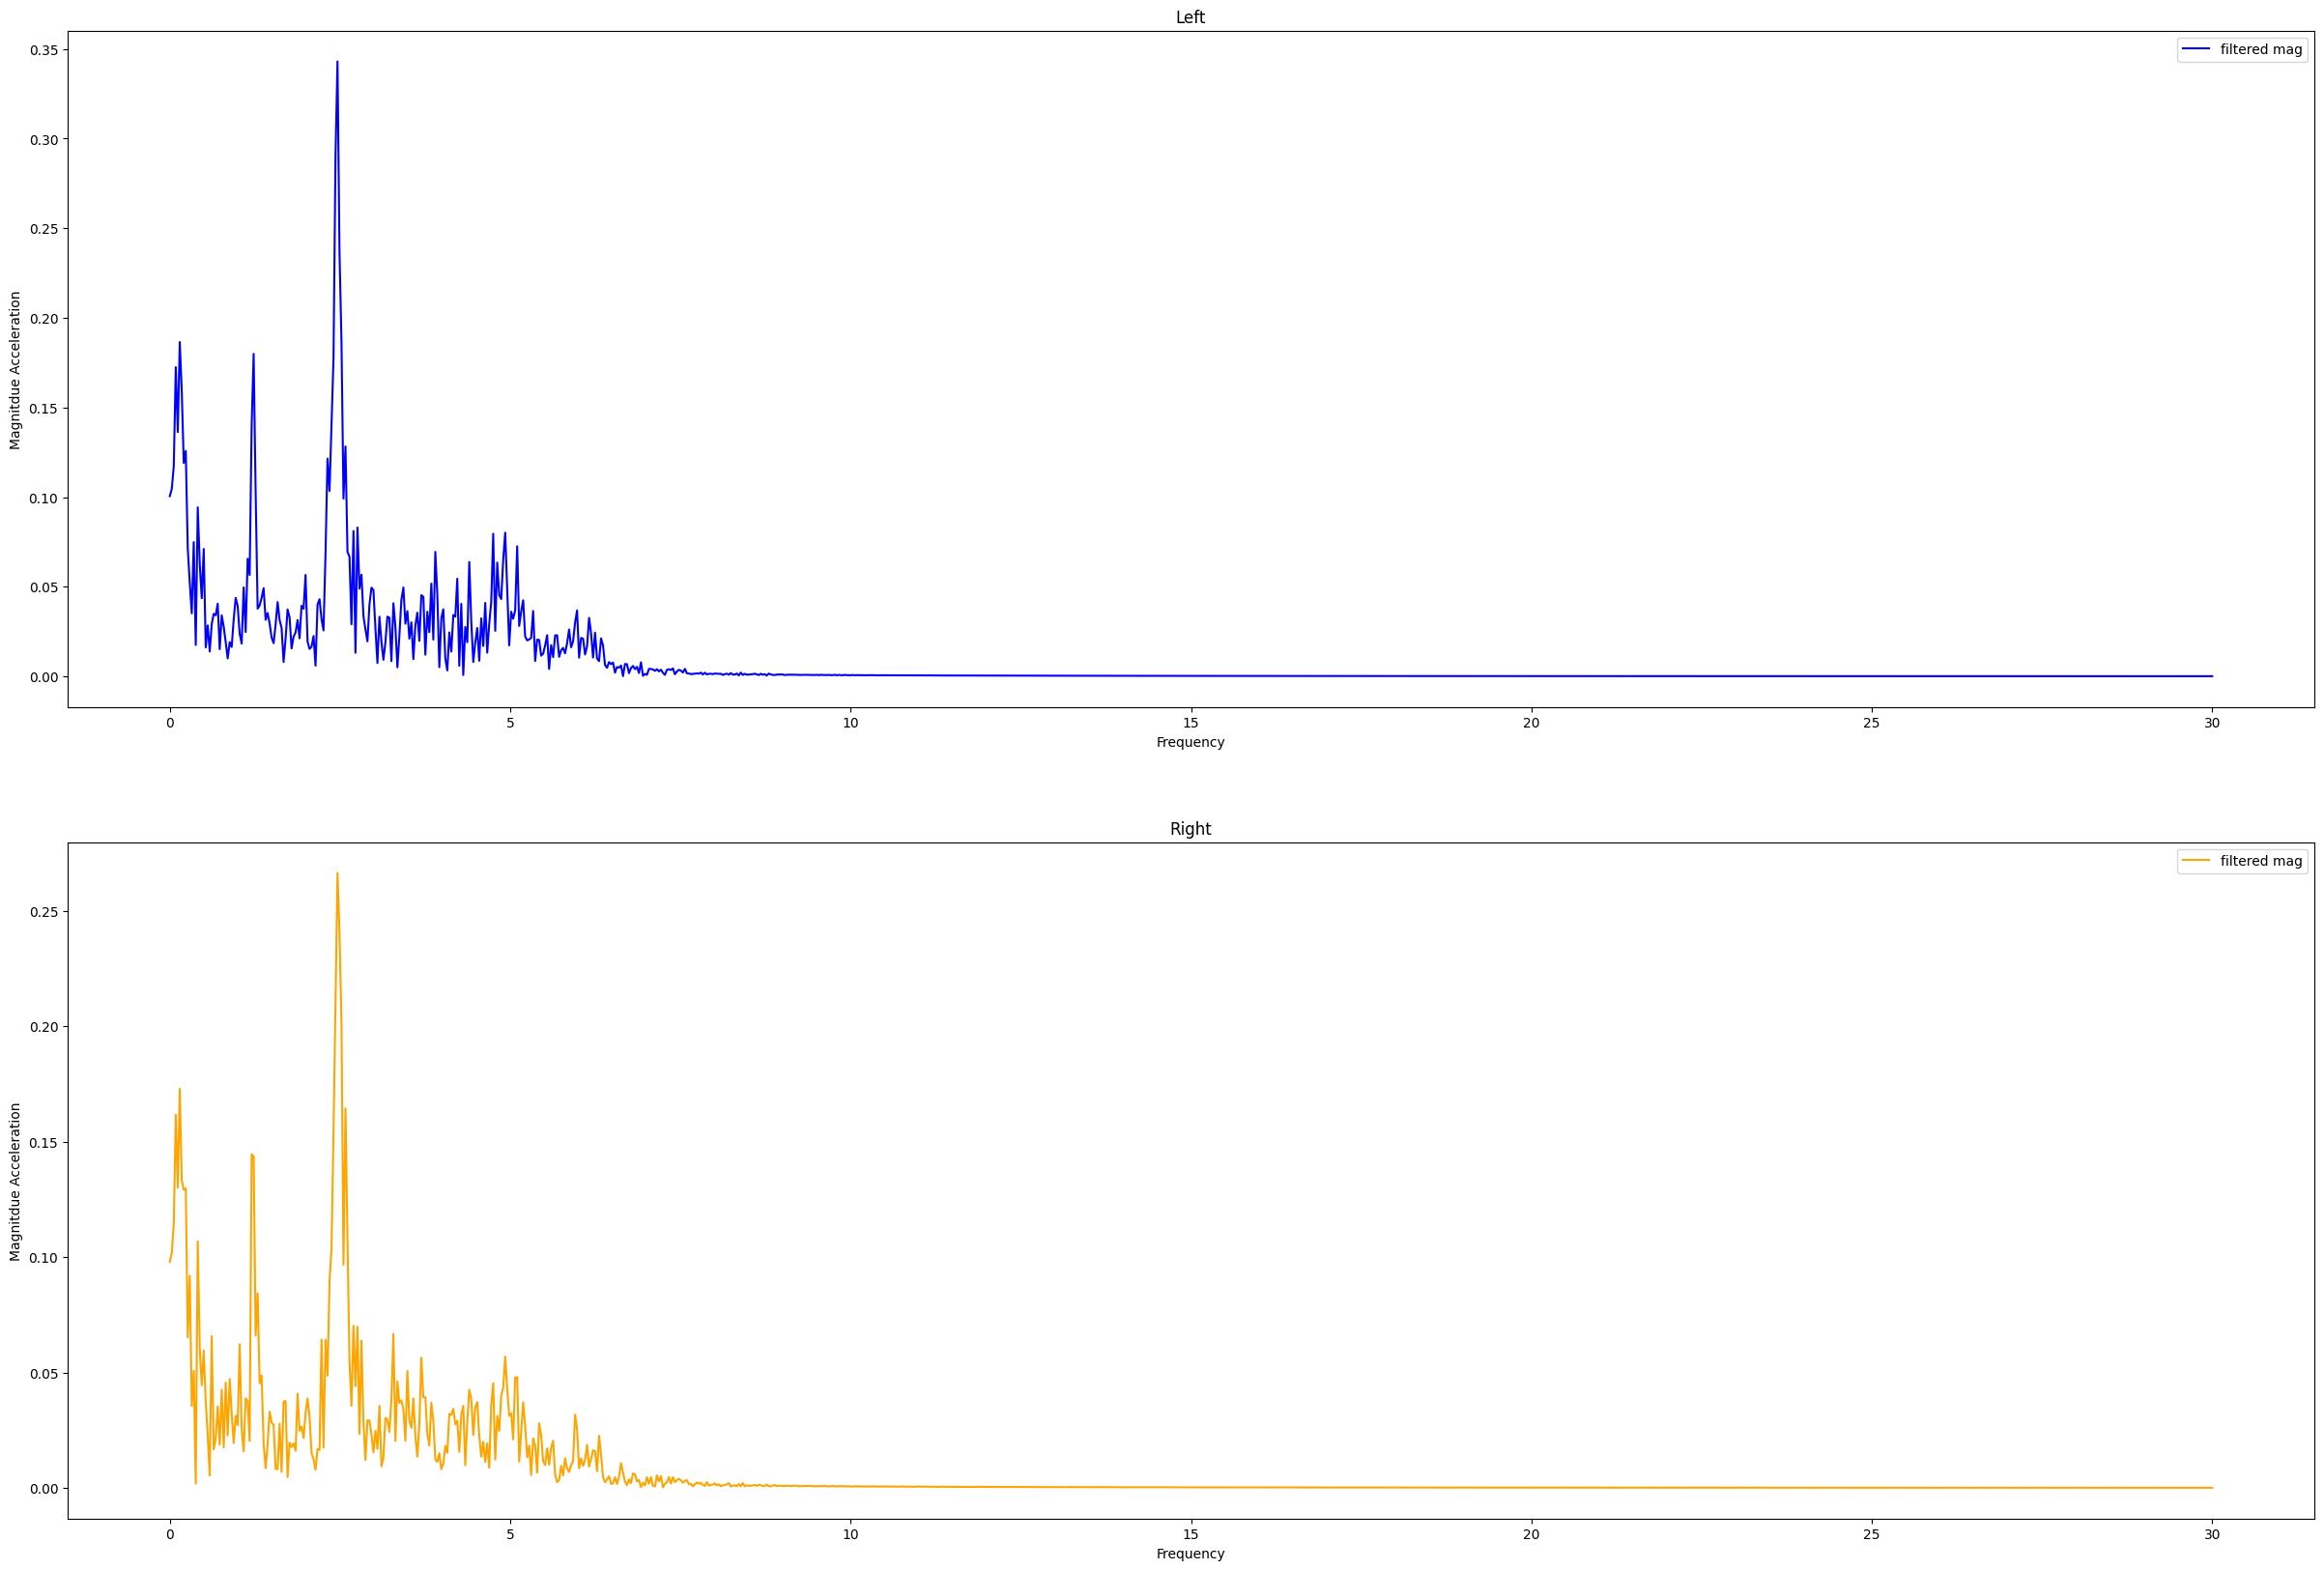

In [7]:
# compute the frequency response
l_fft_mag = h.compute_fft_mag(l_filtered_mag)
r_fft_mag = h.compute_fft_mag(r_filtered_mag)

# create a frequency response graph
l_fft_graph = h.fft_graph_values(l_fft_mag, sampling_rate)
r_fft_graph = h.fft_graph_values(r_fft_mag, sampling_rate)

fig, ax = plt.subplots(2,1, figsize=(30, 20))

# Add labels, title, and legend
ax[0].plot(l_fft_graph[0], l_fft_graph[1], color="blue", label="filtered mag")
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Magnitdue Acceleration')
ax[0].set_title('Left')
ax[0].legend()

ax[1].plot(r_fft_graph[0], r_fft_graph[1], color="orange", label="filtered mag")
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Magnitdue Acceleration')
ax[1].set_title('Right')
ax[1].legend()


In [8]:
# compute the loading intensity 
l_li = h.compute_loading_intensity(l_fft_mag, sampling_rate, hc_off)
r_li = h.compute_loading_intensity(r_fft_mag, sampling_rate, hc_off)
print(f"left {l_li} BW/s, right {r_li} BW/s")

left 22.594811941766576 BW/s, right 19.633404731773574 BW/s
